# Set-up

In [196]:
from google.cloud import bigquery
from google.oauth2 import service_account

import pandas as pd
import pandas_gbq
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Objetivo com as credenciais
credentials = service_account.Credentials.from_service_account_file(
    filename='credentials_gcp_postech_v4.json',
    scopes=['https://www.googleapis.com/auth/bigquery']
)

# Funções

In [3]:
def table_porc(df, groupBy, groupToTotal, colToCount='UF'):
    tab = df.groupby(groupBy).agg({colToCount:'count'}).rename(columns={colToCount:'qtd_quest'})
    tab['Total on groupToTotal'] = tab.groupby(groupToTotal).qtd_quest.transform(np.sum) 
    tab['%'] = round((tab['qtd_quest'] / tab['Total on groupToTotal']) * 100, 2)
    return tab

# Leitura de dados

In [4]:
project_id='pos-tech-project'
dataset='pnad'
table_name='analytic_nov_out'

df =  pandas_gbq.read_gbq(credentials=credentials, query_or_table=f"{project_id}.{dataset}.{table_name}")

Downloading: 100%|██████████|


In [5]:
# Checando NULLS
df.isna().sum()

Ano                0
mes                0
UF                 0
CAPITAL       581552
A002               0
               ...  
C007D_desc    473969
C010_desc     471459
C013_desc     730188
E001_desc          0
F001_desc          0
Length: 91, dtype: int64

# Porcentagem de questionário que realizaram teste

In [6]:
tab_porc_test = table_porc(df=df, groupBy=['Ano','mes','B008_desc'], groupToTotal=['Ano','mes']) 
tab_porc_test

/tmp/ipykernel_16241/1363353374.py:3: FutureWarning: The provided callable <function sum at 0x758917594160> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  tab['Total on groupToTotal'] = tab.groupby(groupToTotal).qtd_quest.transform(np.sum)


qtd_quest  Total on groupToTotal      %
Ano  mes B008_desc                                         
2020 10  Ignorado         674                 380461   0.18
         Não           335247                 380461  88.12
         Sim            44540                 380461  11.71
     11  Ignorado         613                 381438   0.16
         Não           330955                 381438  86.77
         Sim            49870                 381438  13.07

# Porcentagem que testou positivo

In [7]:
# Porcentagem sem filtrar as pessoas que realizaram algum teste
df['testou_positivo_covid'] = np.where(
    (df['B009B'] == 1) | (df['B009D'] == 1) | (df['B009F'] == 1), 'Positivo', 'Outros' 
)

table_porc(df=df, groupBy=['Ano','mes','testou_positivo_covid'], groupToTotal=['Ano','mes'])

/tmp/ipykernel_16241/1363353374.py:3: FutureWarning: The provided callable <function sum at 0x758917594160> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  tab['Total on groupToTotal'] = tab.groupby(groupToTotal).qtd_quest.transform(np.sum)


qtd_quest  Total on groupToTotal      %
Ano  mes testou_positivo_covid                                         
2020 10  Outros                    369510                 380461  97.12
         Positivo                   10951                 380461   2.88
     11  Outros                    368986                 381438  96.74
         Positivo                   12452                 381438   3.26

In [8]:
# Porcentagem para pessoas que realizaram o teste
table_porc(df=df[df['B008_desc'] == 'Sim'], groupBy=['Ano','mes','testou_positivo_covid'], groupToTotal=['Ano','mes'])

/tmp/ipykernel_16241/1363353374.py:3: FutureWarning: The provided callable <function sum at 0x758917594160> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  tab['Total on groupToTotal'] = tab.groupby(groupToTotal).qtd_quest.transform(np.sum)


qtd_quest  Total on groupToTotal      %
Ano  mes testou_positivo_covid                                         
2020 10  Outros                     33589                  44540  75.41
         Positivo                   10951                  44540  24.59
     11  Outros                     37418                  49870  75.03
         Positivo                   12452                  49870  24.97

# Sintomas mais frequentes

In [9]:
df['teve_sintoma'] = np.where(
    (df['B0011_desc'] == 'Sim') |
    (df['B0012_desc'] == 'Sim') |
    (df['B0013_desc'] == 'Sim') |
    (df['B0014_desc'] == 'Sim') |
    (df['B0015_desc'] == 'Sim') |
    (df['B0016_desc'] == 'Sim') |
    (df['B0017_desc'] == 'Sim') |
    (df['B0018_desc'] == 'Sim') |
    (df['B0019_desc'] == 'Sim') |
    (df['B00110_desc'] == 'Sim') |
    (df['B00111_desc'] == 'Sim') |
    (df['B00112_desc'] == 'Sim') |
    (df['B00113_desc'] == 'Sim'), 'Sim', 'Não'
)

In [13]:
df_sintomas = df[['Ano','mes', 'teve_sintoma','B0011_desc', 'B0012_desc',
       'B0013_desc', 'B0014_desc', 'B0015_desc', 'B0016_desc', 'B0017_desc',
       'B0018_desc', 'B0019_desc', 'B00110_desc', 'B00111_desc', 'B00112_desc',
       'B00113_desc']]

df_sintomas = df_sintomas.rename(
    columns={
        'B0011_desc':'febre', 'B0012_desc':'tosse',
       'B0013_desc':'dor de garganta', 'B0014_desc':'dificuldade de respirar', 'B0015_desc':'dor de cabeça', 'B0016_desc':'dor no peito', 'B0017_desc':'náusea',
       'B0018_desc':'nariz entupido ou escorrendo', 'B0019_desc':'fadiga', 'B00110_desc':'dor nos olhos', 'B00111_desc':'perda de cheiro ou sabor', 'B00112_desc':'dor muscular',
       'B00113_desc':'diarreia'
    }
).reset_index() # Cada index é um questionário

df_sintomas = pd.melt(
    frame=df_sintomas, 
    id_vars=['Ano','mes','teve_sintoma','index'], 
    value_vars=['febre','tosse','dor de garganta','dificuldade de respirar','dor de cabeça',
                'dor no peito','náusea','nariz entupido ou escorrendo','fadiga','dor nos olhos',
                'perda de cheiro ou sabor','dor muscular','diarreia'], 
    var_name='sintoma', 
    value_name='resposta'
)

In [153]:
# Qtd de questionário que tiveram pelo menos um sintoma
tab_teve_sintoma =  table_porc(df=df, groupBy=['Ano','mes','teve_sintoma'], groupToTotal=['Ano','mes'])
# tab_teve_sintoma['ano-mes'] = tab_teve_sintoma['Ano'].astype('str') + tab_teve_sintoma['mes'].astype('str')
# tab_teve_sintoma = tab_teve_sintoma.drop(columns=['Ano','mes'])
tab_teve_sintoma = tab_teve_sintoma.reset_index()
tab_teve_sintoma = tab_teve_sintoma[tab_teve_sintoma['teve_sintoma'] == 'Sim']
tab_teve_sintoma = tab_teve_sintoma[['Ano','mes','qtd_quest','%']].rename(columns={'qtd_quest':'qtd_quest_com_sintoma'})
tab_teve_sintoma

/tmp/ipykernel_16241/1363353374.py:3: FutureWarning: The provided callable <function sum at 0x758917594160> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  tab['Total on groupToTotal'] = tab.groupby(groupToTotal).qtd_quest.transform(np.sum)


,Ano,mes,qtd_quest_com_sintoma,%
1,2020,10,13958,3.67
3,2020,11,14130,3.7


In [154]:
# Tabela com a qtd de questionarios que tiver determinado sintoma 
tab_sintomas = df_sintomas[
    (df_sintomas['teve_sintoma'] == 'Sim') & 
    (df_sintomas['resposta'] == 'Sim')
].groupby('sintoma').agg({'index':'count'}).rename(
    columns={'index':'qtd_quest'}
).sort_values(
    by=['qtd_quest'], ascending=True
).reset_index().reset_index()

tab_sintomas['index_sintoma'] = tab_sintomas['index'] + 1
# tab_sintomas

In [156]:
tab_freq_sintomas = table_porc(
    df=df_sintomas[df_sintomas['teve_sintoma'] == 'Sim'], 
    groupBy=['Ano','mes','sintoma','resposta'], 
    groupToTotal=['Ano','mes'], 
    colToCount='index'
).reset_index()

tab_freq_sintomas = tab_freq_sintomas[tab_freq_sintomas['resposta'] == 'Sim'].sort_values(by=['Ano','mes','qtd_quest'], ascending=[True,True,False])

# Adicionando a qtd de questionario que tiveram sintomas no mes
tab_freq_sintomas = tab_freq_sintomas[['Ano','mes','sintoma','qtd_quest']].set_index(['Ano','mes']).join(
    tab_teve_sintoma[['Ano','mes','qtd_quest_com_sintoma']].set_index(['Ano','mes']),
    on=['Ano','mes'],
    how='left'
).reset_index()

# Adicionando o index_sintoma
tab_freq_sintomas = tab_freq_sintomas.set_index('sintoma').join(
    tab_sintomas[['index_sintoma','sintoma']].set_index('sintoma'),
    on='sintoma',
    how='left'
).reset_index()

tab_freq_sintomas['%'] = round((tab_freq_sintomas['qtd_quest'] / tab_freq_sintomas['qtd_quest_com_sintoma']) * 100, 2)

/tmp/ipykernel_16241/1363353374.py:3: FutureWarning: The provided callable <function sum at 0x758917594160> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  tab['Total on groupToTotal'] = tab.groupby(groupToTotal).qtd_quest.transform(np.sum)


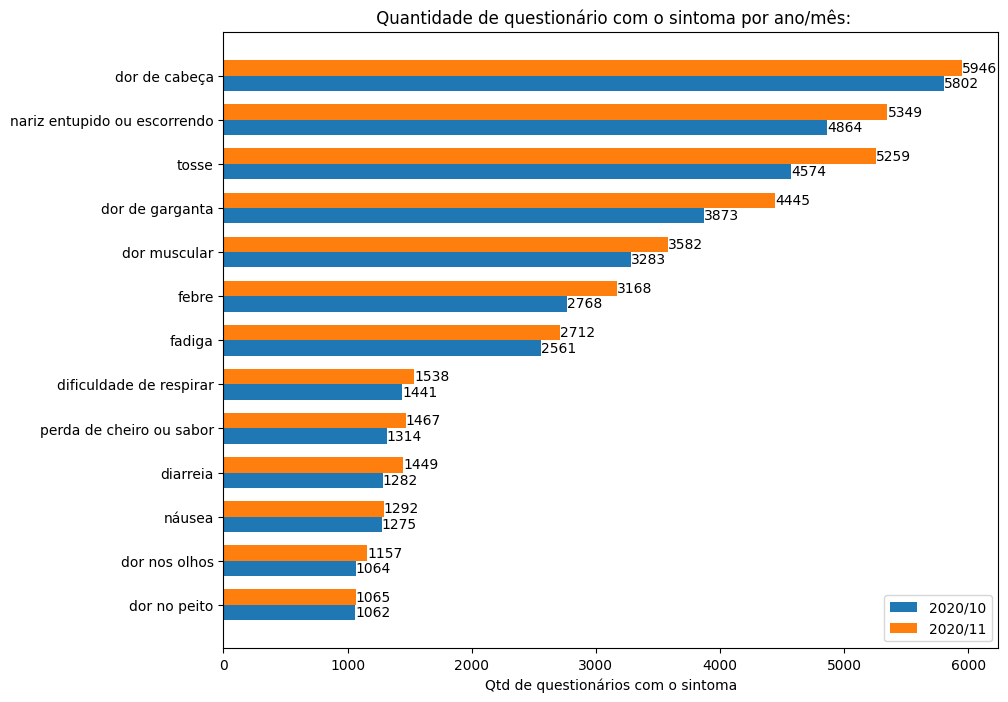

In [157]:
filter_202010 = tab_freq_sintomas[tab_freq_sintomas['mes']== 10].sort_values(by=['index_sintoma'], ascending=True)
filter_202011 = tab_freq_sintomas[tab_freq_sintomas['mes']== 11].sort_values(by=['index_sintoma'], ascending=True)
largura = 0.35

fig, ax = plt.subplots(figsize=(10,8))
g_202010 = ax.barh(np.array(filter_202010['index_sintoma']) - (largura/2), filter_202010['qtd_quest'], height=largura, label='2020/10')
g_202011 = ax.barh(np.array(filter_202011['index_sintoma']) + (largura/2), filter_202011['qtd_quest'], height=largura, label='2020/11')
ax.set_title(" Quantidade de questionário com o sintoma por ano/mês:")
ax.legend()

ax.set_xlabel("Qtd de questionários com o sintoma")
ax.set_yticks(np.array(tab_sintomas['index_sintoma']))
ax.set_yticklabels(np.array(tab_sintomas['sintoma']))
# ax.set_ylim([0,6000])

# Adicionar rótulos para o g_202010
for bar in g_202010:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{bar.get_width():.0f}', 
             va='center', ha='left', fontsize=10)
    
# Adicionar rótulos acima o g_202010
for bar in g_202011:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{bar.get_width():.0f}', 
             va='center', ha='left', fontsize=10)

plt.show()

# Porcentagem de pessoas que tem sintomas e procuram ajuda médica 

In [175]:
table_porc(df=df, groupBy=['Ano','mes','teve_sintoma'], groupToTotal=['Ano','mes'])

/tmp/ipykernel_16241/1363353374.py:3: FutureWarning: The provided callable <function sum at 0x758917594160> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  tab['Total on groupToTotal'] = tab.groupby(groupToTotal).qtd_quest.transform(np.sum)


qtd_quest  Total on groupToTotal      %
Ano  mes teve_sintoma                                         
2020 10  Não              366503                 380461  96.33
         Sim               13958                 380461   3.67
     11  Não              367308                 381438   96.3
         Sim               14130                 381438    3.7

In [178]:
table_porc(df=df, groupBy=['Ano','mes','teve_sintoma','B002_desc'], groupToTotal=['Ano','mes','teve_sintoma']).rename(columns={'Total on groupToTotal':'qtd_quest_com_sintoma_no_mes'})

/tmp/ipykernel_16241/1363353374.py:3: FutureWarning: The provided callable <function sum at 0x758917594160> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  tab['Total on groupToTotal'] = tab.groupby(groupToTotal).qtd_quest.transform(np.sum)


qtd_quest  qtd_quest_com_sintoma_no_mes  \
Ano  mes teve_sintoma B002_desc                                            
2020 10  Sim          Ignorado           5                         13958   
                      Não            10293                         13958   
                      Sim             3660                         13958   
     11  Sim          Ignorado           5                         14130   
                      Não            10096                         14130   
                      Sim             4029                         14130   

                                     %  
Ano  mes teve_sintoma B002_desc         
2020 10  Sim          Ignorado    0.04  
                      Não        73.74  
                      Sim        26.22  
     11  Sim          Ignorado    0.04  
                      Não        71.45  
                      Sim        28.51

# Internação / intubação

In [170]:
df[['Ano','mes','B002_desc','B005','B005_desc','B006','B006_desc','UF']].notnull().sum()

Ano          761899
mes          761899
B002_desc     28088
B005           3951
B005_desc      3951
B006            380
B006_desc       380
UF           761899
dtype: int64

In [179]:
table_porc(df=df, groupBy=['Ano','mes','teve_sintoma','B002_desc','B005_desc'], groupToTotal=['Ano','mes']).reset_index().rename(
    columns={
        'B002_desc':'Procurou um estabelecimento de saúde ?',
        'B005_desc':'Foi internado ?'
    }
)

/tmp/ipykernel_16241/1363353374.py:3: FutureWarning: The provided callable <function sum at 0x758917594160> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  tab['Total on groupToTotal'] = tab.groupby(groupToTotal).qtd_quest.transform(np.sum)


,Ano,mes,teve_sintoma,Procurou um estabelecimento de saúde ?,Foi internado ?,qtd_quest,Total on groupToTotal,%
0,2020,10,Sim,Sim,Não,1650,1852,89.09
1,2020,10,Sim,Sim,Não foi atendido,20,1852,1.08
2,2020,10,Sim,Sim,Sim,182,1852,9.83
3,2020,11,Sim,Sim,Ignorado,3,2099,0.14
4,2020,11,Sim,Sim,Não,1873,2099,89.23
5,2020,11,Sim,Sim,Não foi atendido,25,2099,1.19
6,2020,11,Sim,Sim,Sim,198,2099,9.43


# Funil

In [185]:
df['teve_sintoma_num'] = np.where(df['teve_sintoma'] == 'Sim', 1, 0)
df['proc_med_num'] = np.where(df['B002_desc'] == 'Sim', 1, 0)
df['internado_num'] = np.where(df['B005_desc'] == 'Sim', 1, 0)
df['intubado_num'] = np.where(df['B006_desc'] == 'Sim', 1, 0)

df.groupby(['Ano','mes'])[['teve_sintoma_num','proc_med_num','internado_num','intubado_num']].sum().rename(
    columns={
        'teve_sintoma_num':'Qtd. que tem algum sintoma:',
        'proc_med_num':'Qtd.  que procurou um estabelicimento de saúde:',
        'internado_num':'Qtd. internada:',
        'intubado_num':'Qtd. intubada:'
        }
).T


Ano                                               2020       
mes                                                 10     11
Qtd. que tem algum sintoma:                      13958  14130
Qtd.  que procurou um estabelicimento de saúde:   3660   4029
Qtd. internada:                                    182    198
Qtd. intubada:                                      44     39

In [186]:
# porcentagem de internações média
(182+198)/(3660+4029)

0.049421251137989335

In [187]:
# porcentagem de intubações média
(44+39)/(3660+4029)

0.010794641695929249

# Idade

In [192]:
df['testou_positivo_covid']

0         Outros
1         Outros
2         Outros
3         Outros
4         Outros
           ...  
761894    Outros
761895    Outros
761896    Outros
761897    Outros
761898    Outros
Name: testou_positivo_covid, Length: 761899, dtype: object

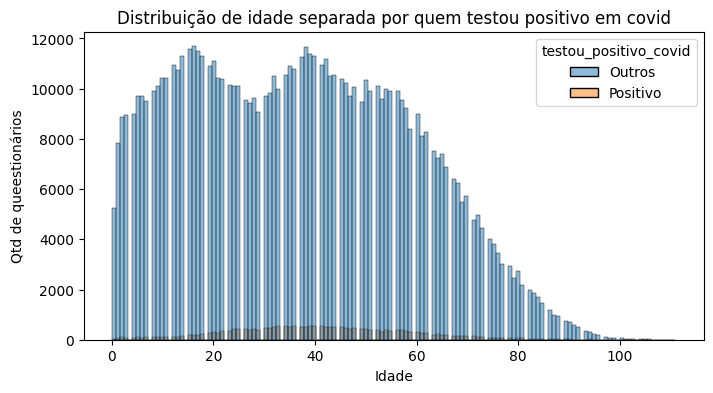

In [203]:
# Distribuição de idade separada por quem testou positivo em covid
fig = plt.figure(figsize = (8, 4))
ax = sns.histplot(x = df['A002'], hue = df['testou_positivo_covid'])
ax.set_xlabel("Idade")
ax.set_ylabel("Qtd de queestionários")
ax.set_title("Distribuição de idade separada por quem testou positivo em covid")
plt.show()

# Sexo

In [206]:
# df['A003_desc']
table_porc(df=df, groupBy=['Ano','mes','A003_desc'], groupToTotal=['Ano','mes'])

/tmp/ipykernel_16241/1363353374.py:3: FutureWarning: The provided callable <function sum at 0x758917594160> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  tab['Total on groupToTotal'] = tab.groupby(groupToTotal).qtd_quest.transform(np.sum)


qtd_quest  Total on groupToTotal      %
Ano  mes A003_desc                                         
2020 10  Homem         182309                 380461  47.92
         Mulher        198152                 380461  52.08
     11  Homem         182611                 381438  47.87
         Mulher        198827                 381438  52.13

In [207]:
table_porc(df=df, groupBy=['Ano','mes','A003_desc','testou_positivo_covid'], groupToTotal=['Ano','mes'])

/tmp/ipykernel_16241/1363353374.py:3: FutureWarning: The provided callable <function sum at 0x758917594160> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  tab['Total on groupToTotal'] = tab.groupby(groupToTotal).qtd_quest.transform(np.sum)


qtd_quest  Total on groupToTotal  \
Ano  mes A003_desc testou_positivo_covid                                     
2020 10  Homem     Outros                    177420                 380461   
                   Positivo                    4889                 380461   
         Mulher    Outros                    192090                 380461   
                   Positivo                    6062                 380461   
     11  Homem     Outros                    177032                 381438   
                   Positivo                    5579                 381438   
         Mulher    Outros                    191954                 381438   
                   Positivo                    6873                 381438   

                                              %  
Ano  mes A003_desc testou_positivo_covid         
2020 10  Homem     Outros                 46.63  
                   Positivo                1.29  
         Mulher    Outros                 50.49  
                   Positivo                1.59  
     11  Homem     Outros                 46.41  
                   Positivo                1.46  
         Mulher    Outros                 50.32  
                   Positivo                 1.8

# Categoria de trabalho

In [209]:
df['C007_desc']

0                                                      None
1                                                      None
2                                                      None
3                                                      None
4                                                      None
                                ...                        
761894    Empregado do setor público (inclusive empresas...
761895    Empregado do setor público (inclusive empresas...
761896                                           Empregador
761897                                        Conta própria
761898                           Empregado do setor privado
Name: C007_desc, Length: 761899, dtype: object

In [219]:
df['testou_positivo_covid_num'] = np.where(df['testou_positivo_covid'] == 'Positivo', 1, 0)

tab_prof = df.groupby('C007_desc',dropna=False).agg({'UF':'count', 'testou_positivo_covid_num':'sum'}).reset_index()
tab_prof = tab_prof.rename(columns={'C007_desc':'profissão', 'UF':'qtd quest', 'testou_positivo_covid_num':'qtd positivo covid'})

tab_prof['% positivos'] = round((tab_prof['qtd positivo covid']/tab_prof['qtd quest'])*100, 2)
tab_prof.sort_values('% positivos', ascending=False).set_index('profissão')

,qtd quest,qtd positivo covid,% positivos
profissão,,,
Plicial militar ou bombeiro mlilitar,1351,174,12.88
"Militar do exercito, marinha ou aeronáutica",1159,114,9.84
Empregado do setor público (inclusive empresas de economia mista),43688,3503,8.02
Empregador,8806,532,6.04
Empregado do setor privado,124918,5956,4.77
Conta própria,88760,2757,3.11
"Trabalhador doméstico (empregado doméstico, cuidados, babá)",14883,461,3.1
Trabalhador familiar não remunerado em ajuda a membro do domicílio ou parente,6875,195,2.84
NaN,461162,9569,2.07


# Home-office

In [228]:
tab_homeoff = df.groupby(['Ano','mes','C013_desc'],dropna=False).agg({'UF':'count', 'testou_positivo_covid_num':'sum'}).reset_index()
tab_homeoff = tab_homeoff.rename(columns={'C013_desc':'home_office', 'UF':'qtd quest', 'testou_positivo_covid_num':'qtd positivo covid'})

tab_homeoff['% positivos'] = round((tab_homeoff['qtd positivo covid']/tab_homeoff['qtd quest'])*100, 2)
tab_homeoff.sort_values('qtd positivo covid', ascending=False).set_index('home_office')
tab_homeoff.set_index(['Ano','mes','home_office'])

qtd quest  qtd positivo covid  % positivos
Ano  mes home_office                                            
2020 10  Não               4913                 158         3.22
         Sim              11117                 473         4.25
         NaN             364431               10320         2.83
     11  Não               4818                 186         3.86
         Sim              10863                 580         5.34
         NaN             365757               11686          3.2

In [226]:
1053/21980

0.047907188353048226

# Emprestimo na pandemia

In [229]:
df['E001_desc']

0                                  Não solicitou
1                                  Não solicitou
2         Sim, e pelo menos um morador conseguiu
3                                  Não solicitou
4                                  Não solicitou
                           ...                  
761894                             Não solicitou
761895                             Não solicitou
761896                             Não solicitou
761897                             Não solicitou
761898                             Não solicitou
Name: E001_desc, Length: 761899, dtype: object

In [230]:
tab_emp = df.groupby(['Ano','mes','E001_desc'],dropna=False).agg({'UF':'count', 'testou_positivo_covid_num':'sum'}).reset_index()
tab_emp = tab_emp.rename(columns={'E001_desc':'solicitou emprestimo', 'UF':'qtd quest', 'testou_positivo_covid_num':'qtd positivo covid'})

tab_emp['% positivos'] = round((tab_emp['qtd positivo covid']/tab_emp['qtd quest'])*100, 2)
tab_emp.sort_values('qtd positivo covid', ascending=False).set_index('solicitou emprestimo')
tab_emp.set_index(['Ano','mes','solicitou emprestimo'])

qtd quest  \
Ano  mes solicitou emprestimo                                
2020 10  Não solicitou                              347878   
         Sim, e pelo menos um morador conseguiu      28134   
         Sim, mas nenhum morador conseguiu            4449   
     11  Não solicitou                              346162   
         Sim, e pelo menos um morador conseguiu      30835   
         Sim, mas nenhum morador conseguiu            4441   

                                                 qtd positivo covid  \
Ano  mes solicitou emprestimo                                         
2020 10  Não solicitou                                         9727   
         Sim, e pelo menos um morador conseguiu                1091   
         Sim, mas nenhum morador conseguiu                      133   
     11  Não solicitou                                        10908   
         Sim, e pelo menos um morador conseguiu                1370   
         Sim, mas nenhum morador conseguiu                      174   

                                                 % positivos  
Ano  mes solicitou emprestimo                                 
2020 10  Não solicitou                                   2.8  
         Sim, e pelo menos um morador conseguiu         3.88  
         Sim, mas nenhum morador conseguiu              2.99  
     11  Não solicitou                                  3.15  
         Sim, e pelo menos um morador conseguiu         4.44  
         Sim, mas nenhum morador conseguiu              3.92

In [233]:
tab_emp2 = table_porc(df=df, groupBy=['Ano','mes','E001_desc'], groupToTotal=['Ano','mes']).reset_index()
tab_emp2.rename(columns={'E001_desc':'solitou emprestimo na pandemia ?', 'Total on groupToTotal':'qtd_quest_mes'}).set_index(['Ano','mes'])

/tmp/ipykernel_16241/1363353374.py:3: FutureWarning: The provided callable <function sum at 0x758917594160> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  tab['Total on groupToTotal'] = tab.groupby(groupToTotal).qtd_quest.transform(np.sum)


solitou emprestimo na pandemia ?  qtd_quest  qtd_quest_mes  \
Ano  mes                                                                     
2020 10                            Não solicitou     347878         380461   
     10   Sim, e pelo menos um morador conseguiu      28134         380461   
     10        Sim, mas nenhum morador conseguiu       4449         380461   
     11                            Não solicitou     346162         381438   
     11   Sim, e pelo menos um morador conseguiu      30835         381438   
     11        Sim, mas nenhum morador conseguiu       4441         381438   

              %  
Ano  mes         
2020 10   91.44  
     10    7.39  
     10    1.17  
     11   90.75  
     11    8.08  
     11    1.16